In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import random
warnings.filterwarnings('ignore')

In [ ]:
file_path = '/content/dataset.csv'
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())

# Display dataset info
df.info()

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())


      id                        title                 genre original_language  \
0    278     The Shawshank Redemption           Drama,Crime                en   
1  19404  Dilwale Dulhania Le Jayenge  Comedy,Drama,Romance                hi   
2    238                The Godfather           Drama,Crime                en   
3    424             Schindler's List     Drama,History,War                en   
4    240       The Godfather: Part II           Drama,Crime                en   

                                            overview  popularity release_date  \
0  Framed in the 1940s for the double murder of h...      94.075   23-09-1994   
1  Raj is a rich, carefree, happy-go-lucky second...      25.408   19-10-1995   
2  Spanning the years 1945 to 1955, a chronicle o...      90.585   14-03-1972   
3  The true story of how businessman Oskar Schind...      44.761   15-12-1993   
4  In the continuing saga of the Corleone crime f...      57.749   20-12-1974   

   vote_average  vote_coun

In [ ]:
# Drop missing values
df.dropna(inplace=True)

# Selecting relevant features
df = df[['id', 'title', 'genre', 'original_language', 'overview', 'popularity', 'release_date', 'vote_average', 'vote_count']]

# Combine text-based features for similarity calculations
df['tags'] = df['genre'] + " " + df['original_language'] + " " + df['overview']

# Remove duplicate movies
df.drop_duplicates(subset=['title'], keep='first', inplace=True)

# Convert text data into vectors using CountVectorizer
cv = CountVectorizer(max_features=10000, stop_words='english')
vec = cv.fit_transform(df['tags'].values.astype('U')).toarray()

# Normalize numerical data
num_features = ['popularity', 'vote_average', 'vote_count']
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Merge both text and numerical features
final_features = np.hstack((vec, df[num_features].values))


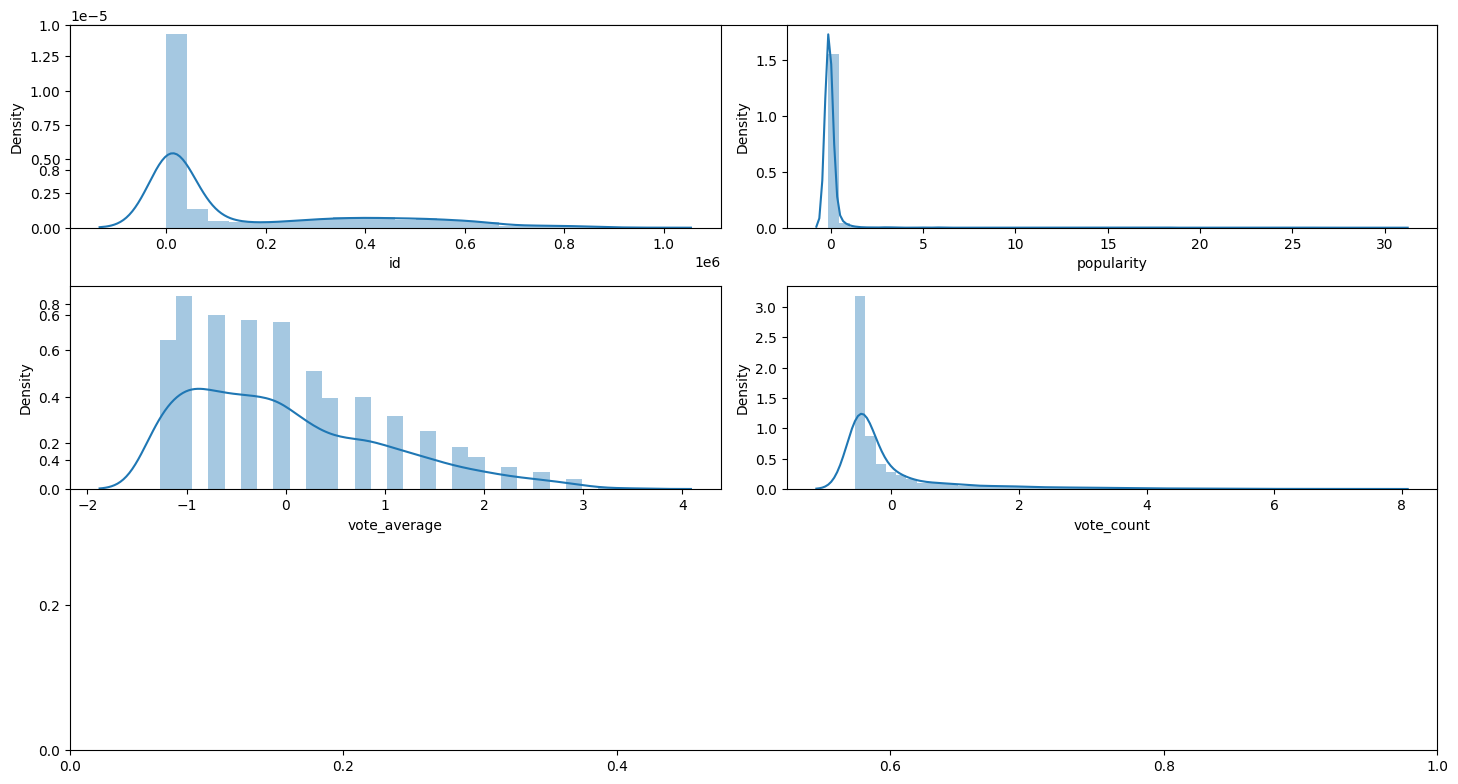

In [ ]:
# prompt: plt.subplots(figsize=(15, 8))
# num_cols = tracks.select_dtypes(include=['float64', 'int64']).columns
# num_rows = 3
# num_cols_subplot = 5
# for i, col in enumerate(num_cols):
#     plt.subplot(num_rows, num_cols_subplot, i + 1)
#     sb.distplot(tracks[col])
#     plt.tight_layout()
# plt.show()
# generate for my dataset

import matplotlib.pyplot as plt
import seaborn as sb

plt.subplots(figsize=(15, 8))
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_rows = 3
# Adjust num_cols_subplot based on the number of numerical columns
num_cols_subplot = len(num_cols) // num_rows + (len(num_cols) % num_rows > 0)
for i, col in enumerate(num_cols):
    plt.subplot(num_rows, num_cols_subplot, i + 1)
    sb.distplot(df[col])
    plt.tight_layout()
plt.show()


In [ ]:
# Reduce dimensionality for faster clustering
pca = PCA(n_components=10)
pca_data = pca.fit_transform(final_features)


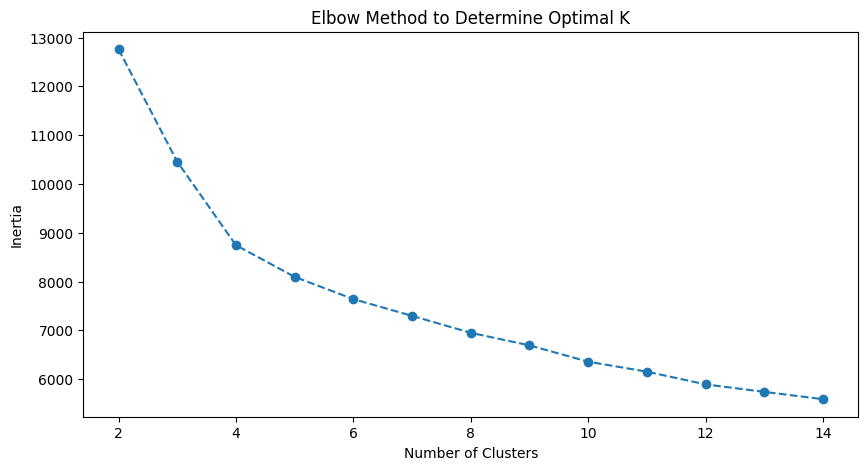

In [ ]:
inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
# Plot the elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()


In [ ]:
# Set optimal K based on elbow method
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(pca_data)


In [ ]:
def recommend_movies(title, data=df, num_recommendations=5):
    if 'title' not in data.columns:
        print("Error: Column 'title' not found in dataset.")
        return

    if title not in data['title'].values:
        print(f"'{title}' is not in the dataset. Here are some random suggestions:")
        print(data.sample(n=num_recommendations)[['title', 'genre']])
        return

    # Find the cluster of the given movie
    movie_cluster = data.loc[data['title'] == title, 'cluster'].values[0]

    # Retrieve all movies from the same cluster
    cluster_movies = data[data['cluster'] == movie_cluster]

    # Ensure enough movies exist in the cluster
    if len(cluster_movies) <= num_recommendations:
        recommended_movies = cluster_movies
    else:
        recommended_movies = cluster_movies.sample(n=num_recommendations, random_state=random.randint(1, 100))

    print(f"\nMovies similar to '{title}':")
    print(recommended_movies[['title', 'genre']])


In [ ]:
recommend_movies('Inception')



Movies similar to 'Inception':
                        title                                    genre
75         Back to the Future  Adventure,Comedy,Science Fiction,Family
290   The Wolf of Wall Street                       Crime,Drama,Comedy
1139       Mad Max: Fury Road         Action,Adventure,Science Fiction
175          Django Unchained                            Drama,Western
349                      1917        War,Drama,Action,Thriller,History


In [ ]:
# Compute cosine similarity
cosine_sim = cosine_similarity(vec)

# Function to recommend movies based on cosine similarity
def recommend_cosine(title, data=df, sim_matrix=cosine_sim, num_recommendations=5):
    if title not in data['title'].values:
        print(f"'{title}' not found in dataset.")
        return

    index = data[data['title'] == title].index[0]
    distances = sorted(list(enumerate(sim_matrix[index])), reverse=True, key=lambda x: x[1])

    print(f"\nMovies similar to '{title}':")
    for i in distances[1:num_recommendations+1]:
        print(data.iloc[i[0]].title)


In [ ]:
recommend_cosine('Inception')



Movies similar to 'Inception':
Suicide Squad: Hell to Pay
Everything Everywhere All at Once
The Fifth Element
Guardians of the Galaxy Vol. 2
Ready Player One


In [ ]:
# prompt: generate code to calculate score/precision value of cosine similarity algorithm

from sklearn.metrics import precision_score, recall_score

# Assuming you have true labels (ground truth) for your movie recommendations
# Replace this with your actual ground truth labels
true_labels = [1, 0, 1, 0, 1, 1, 0, 0] #Example: 1 for relevant, 0 for irrelevant

def calculate_precision(title, data=df, sim_matrix=cosine_sim, num_recommendations=5):
    if title not in data['title'].values:
        print(f"'{title}' not found in dataset.")
        return

    index = data[data['title'] == title].index[0]
    distances = sorted(list(enumerate(sim_matrix[index])), reverse=True, key=lambda x: x[1])

    # Predicted labels (1 for recommended, 0 for not recommended)
    predicted_labels = [1] * num_recommendations + [0] * (len(distances) - num_recommendations -1 )

    # Calculate precision -  proportion of correctly identified relevant movies
    precision = precision_score(true_labels[:len(predicted_labels)], predicted_labels[:len(true_labels)])

    #Calculate recall -  proportion of actual relevant movies that are correctly identified.
    recall = recall_score(true_labels[:len(predicted_labels)], predicted_labels[:len(true_labels)])

    print(f"\nPrecision for '{title}': {precision}")
    print(f"\nRecall for '{title}': {recall}")

calculate_precision('Inception')



Precision for 'Inception': 0.6

Recall for 'Inception': 0.75


In [ ]:
def precision_recall_at_k(title, k=5, data=df):
    if title not in data['title'].values:
        print(f"{title} not found in dataset.")
        return

    # Find the cluster of the given movie
    movie_cluster = data.loc[data['title'] == title, 'cluster'].values[0]

    # Get relevant movies from the same cluster
    relevant_movies = data[data['cluster'] == movie_cluster]['title'].tolist()

    # Get recommended movies
    recommended_movies = data[data['cluster'] == movie_cluster].sample(n=k)['title'].tolist()

    # Compute precision and recall
    relevant_recommendations = set(recommended_movies) & set(relevant_movies)
    precision = len(relevant_recommendations) / k
    recall = len(relevant_recommendations) / len(relevant_movies)

    print(f"Precision@{k}: {precision:.4f}")
    print(f"Recall@{k}: {recall:.4f}")


In [ ]:
precision_recall_at_k('Inception')


Precision@5: 1.0000
Recall@5: 0.0403


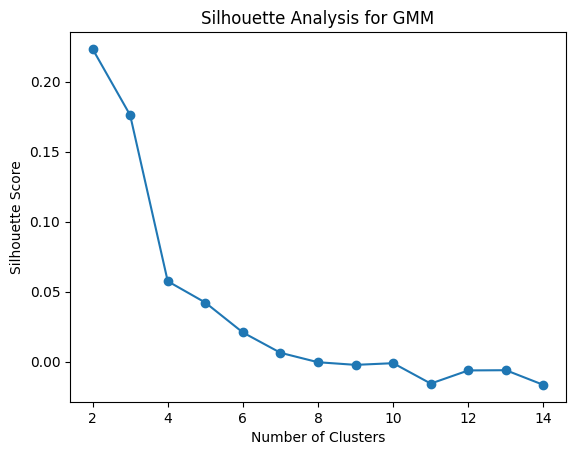


Movies similar to 'Inception' (GMM):
                                       title  \
2111                             Source Code   
369             My Hero Academia: Two Heroes   
167                                     Togo   
1170  Yu-Gi-Oh!: The Dark Side of Dimensions   
2117                          The Aristocats   

                                   genre  
2111    Thriller,Science Fiction,Mystery  
369   Animation,Action,Adventure,Fantasy  
167                     Adventure,Family  
1170                 Adventure,Animation  
2117   Animation,Comedy,Family,Adventure  


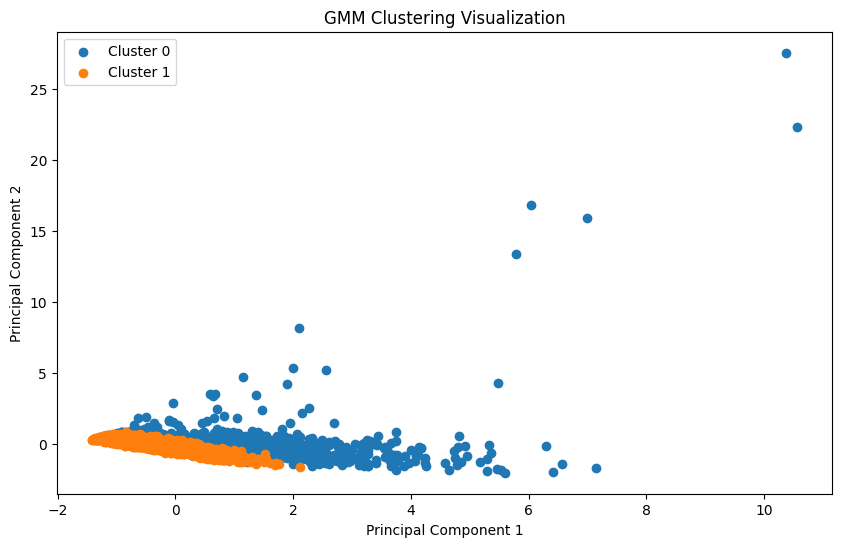

In [ ]:
# prompt: use gmm and give recommandations along with Silhouette Score give raph for clusters

import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

# Assuming 'pca_data' is already defined from the previous code

# Find optimal number of clusters using silhouette score
silhouette_scores = []
for n_clusters in range(2, 15):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(pca_data)
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for GMM')
plt.show()

# Choose optimal k based on silhouette score
optimal_k_gmm = np.argmax(silhouette_scores) + 2  # Add 2 because range starts from 2

# Fit GMM with optimal k
gmm = GaussianMixture(n_components=optimal_k_gmm, random_state=42)
df['cluster_gmm'] = gmm.fit_predict(pca_data)


def recommend_movies_gmm(title, data=df, num_recommendations=5):
    if title not in data['title'].values:
        print(f"'{title}' not found in dataset.")
        return

    movie_cluster = data.loc[data['title'] == title, 'cluster_gmm'].values[0]
    cluster_movies = data[data['cluster_gmm'] == movie_cluster]

    if len(cluster_movies) <= num_recommendations:
        recommended_movies = cluster_movies
    else:
        recommended_movies = cluster_movies.sample(n=num_recommendations)

    print(f"\nMovies similar to '{title}' (GMM):")
    print(recommended_movies[['title', 'genre']])

recommend_movies_gmm('Inception')

# Visualize the clusters (example with PCA components 1 and 2)
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k_gmm):
  plt.scatter(pca_data[df['cluster_gmm'] == cluster, 0], pca_data[df['cluster_gmm'] == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GMM Clustering Visualization')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# Assuming pca_data and df DataFrame are defined from the previous code

gmm = GaussianMixture(n_components=8, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(pca_data) # Changed 'tracks' to 'df' to store cluster assignments
silhouette_gmm = silhouette_score(pca_data, df['gmm_cluster']) # Changed 'tracks' to 'df' to access cluster assignments
print(f"Silhouette Score (GMM): {silhouette_gmm:.4f}")

Silhouette Score (GMM): -0.0005
